In [2]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils

In [14]:
# Batch size
bsize = 64
# number of epochs
epochs = 5
# learning rate
alpha = 0.0002
# beta1
beta1 = 0.5
# beta2
beta2 = 0.999
# Z vector size
nz = 100

# Channels, H, W
img_shape = (1, 28, 28)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor(), tvtransforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=bsize,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)

Using downloaded and verified file: data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw
Using downloaded and verified file: data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Using downloaded and verified file: data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw
Using downloaded and verified file: data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


In [29]:
def discriminator_loss(D_real, D_fake):
    return(-torch.mean(torch.log(D_real) + torch.log(1-D_fake)))

def generator_loss(D_fake):
    return(torch.mean(-torch.log(D_fake)))


In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(nz, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Map to desired image size
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )
        
    def forward(self, z):
        # img is flat and needs to be reshaped
        img = self.model(z)
        # reshape to (batch_size, channels, H, W)
        img = img.view(img.size(0), *img_shape)
        return img
    

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [32]:
gen_model = Generator().to(device)
print(gen_model)

disc_model = Discriminator().to(device)
print(disc_model)

gen_opt = torch.optim.Adam(gen_model.parameters(), lr=alpha, betas=(beta1, beta2))
disc_opt = torch.optim.Adam(disc_model.parameters(), lr=alpha, betas=(beta1, beta2))

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace

In [35]:
g_losses = []
d_losses = []
fixed_img_list = []
fixed_z_vecs = torch.randn(64, nz, device=device)
iters = 0

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader, 0):
        # Run D on real images and get contribution to loss
        disc_model.zero_grad()
        real_imgs = real_imgs.to(device)
        D_real = disc_model(real_imgs)
               
        # Run D on generated fake images and update D's weights
        z_sample = torch.randn(bsize, nz, device=device)
        fake_imgs = gen_model(z_sample)
        D_fake = disc_model(fake.detach())
        
        disc_err = discriminator_loss(D_real, D_fake)
        disc_err.backward()
        disc_opt.step()
        
        # Update G by maximizing log(D(G(z))) where 
        gen_model.zero_grad()
        D_fake = disc_model(fake_imgs)
        
        gen_err = generator_loss(D_fake)
        gen_err.backward()
        gen_opt.step()
        
        if i % 100 == 0:
            print(
                "[{}/{}][{}/{}]"
                .format(
                    epoch, epochs, i, len(dataloader)
                )
            )
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen_model(fixed_z_vecs).detach().cpu()
            fixed_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        g_losses.append(gen_err.item())
        d_losses.append(disc_err.item())
        iters += 1

[0/5][0/937]
[0/5][100/937]
[0/5][200/937]


KeyboardInterrupt: 

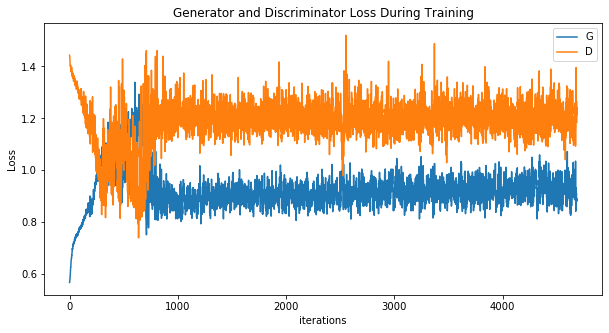

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

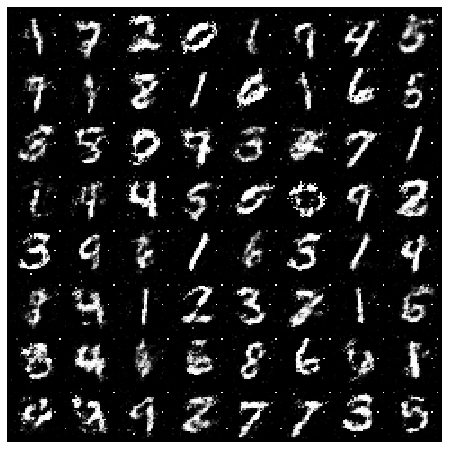

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fixed_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

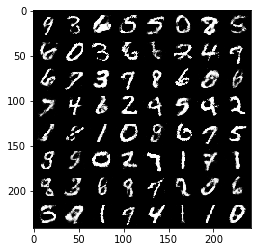

In [36]:
fixed_imgs = gnet(fixed_noise).detach().cpu()
img = torchvision.utils.make_grid(fixed_imgs, padding=2, normalize=True)
plt.figure()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()